# SPレコード画像分類 - 前処理

SPレコードのレーベル画像からレコード会社を推測する画像分類モデルを作成する。

ここでは、画像ファイルからレーベルのみを抜き出す処理について記述する。

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cv2

print('opencv', cv2.__version__)

opencv 4.6.0


## データセット確認

手持ちのSPレコードを適当に選び、スマホで撮影した。この画像ファイルを訓練データとして、予測モデルを作成したい。

まだ数が少ないが、とりあえず215枚用意した。
この215枚をレコード会社別に、ディレクトリに振り分けた。
ディレクトリ名は以下に対応する。

|ディレクトリ名|レコード会社名|画像枚数|
|------------|-----------|-------|
|columbia    |コロムビア   |16|
|nipponophon |ニッポノホン|24|
|orient      |オリエント|6|
|parlophon   |パルロフォン|6|
|regal       |リーガル|22|
|victor      |ビクター|42|
|king        |キング|14|
|nitto       |ニットー|10|   
|polydor     |ポリドール|19|
|taihei      |タイヘイ|16|
|others      |その他|40|

In [2]:
imagefiles = [[str(f) for f in d.iterdir() if f.suffix=='.JPG'] for d in Path('images/orig').iterdir() if d.is_dir()]
imagefiles = sum(imagefiles, [])

In [3]:
!ls images/orig

columbia    nipponophon orient      parlophon   regal       victor
king        nitto       others      polydor     taihei


上記フォルダからランダムに選んで画像を表示してみる。

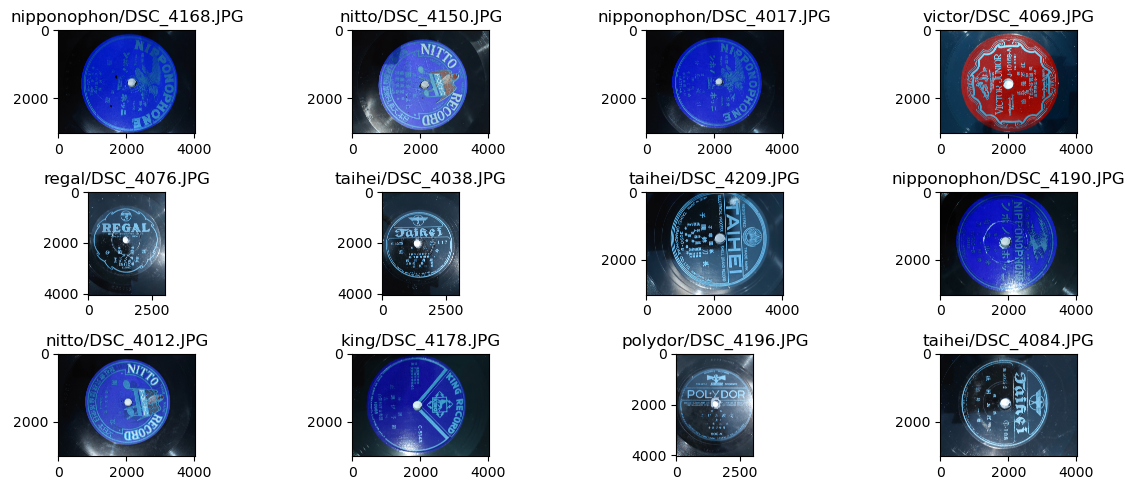

In [4]:
import random

random.seed(0)
l = random.sample(imagefiles, 12)

_, ax = plt.subplots(ncols=4, nrows=3, figsize=(12, 5))
ax = ax.flatten()
for i, imagefile in enumerate(l):
    img = cv2.imread(imagefile)
    ax[i].imshow(img)
    ax[i].set_title(imagefile.replace('images/orig/', ''), fontsize=12)
plt.tight_layout()
plt.show()

見るとわかる通り、画像サイズやレーベルの向きがバラバラである。
ディープラーニングのモデルに入力するためには、背景をなるべく省き、サイズも揃える必要がある。

## レーベルの周辺の正方形を抽出する

幸いなことにレコードのレーベルは円であるため、正方形の形に揃えればレーベルがうまく入る領域を切り出せそうだ。
後でデータ拡張(画像の水増し)を行う時、正方形に揃えていれば任意の角度に回転した画像が使える。

そこで opencv の輪廓抽出機能 `cv2.findContours` を利用して抽出を試みる。

In [5]:
def extract_label(img):
    """
    SP盤のレーベル付近を抽出する
    
    opencvのfindContousを利用し、
    レーベル付近にあるはずの輪廓を求めることにより
    レーベルの存在エリアを推定する。
    
    Parameters
    ----------
    img: np.array
        画像データ
    
    Returns
    -------
    label_img: np.array
        レーベルを抽出した正方形画像データ
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # HSV変換
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
    # 2値化
    img_mask = cv2.inRange(img_hsv, np.array([20, 20, 20]), np.array([255, 255, 255]))
    # 輪廓を求める
    contours, _ = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cs = list(filter(lambda x: cv2.contourArea(x) > 100, contours))

    h, w, _ = img.shape
    if h >= w:
        idx = 1
        l = w
    else:
        idx = 0
        l = h
    
    u = np.empty(shape=0)
    for block in cs:
        u = np.concatenate([u, block[:,:,idx].flatten()])

    center = int((np.max(u)+np.min(u))//2)
    u_min = center - (l//2)
    u_max = u_min + l
    
    # img から u = u_min~u_max の範囲をくりぬく
    if h >= w:
        label_img = img[u_min:u_max,:,:]
    else:
        label_img = img[:,u_min:u_max,:]
    return label_img

抽出したレーベル部分を保存するディレクトリを作成する。

In [6]:
output_dirs = [Path(str(d).replace('orig', 'extract_label')) for d in Path('images/orig').iterdir() if d.is_dir()]
for outd in output_dirs:
    if not outd.exists():
        outd.mkdir()

レーベルの抽出を行い、ファイルに保存する。

0 images/orig/parlophon/DSC_4051.JPGを処理中です...
20 images/orig/victor/DSC_4118.JPGを処理中です...


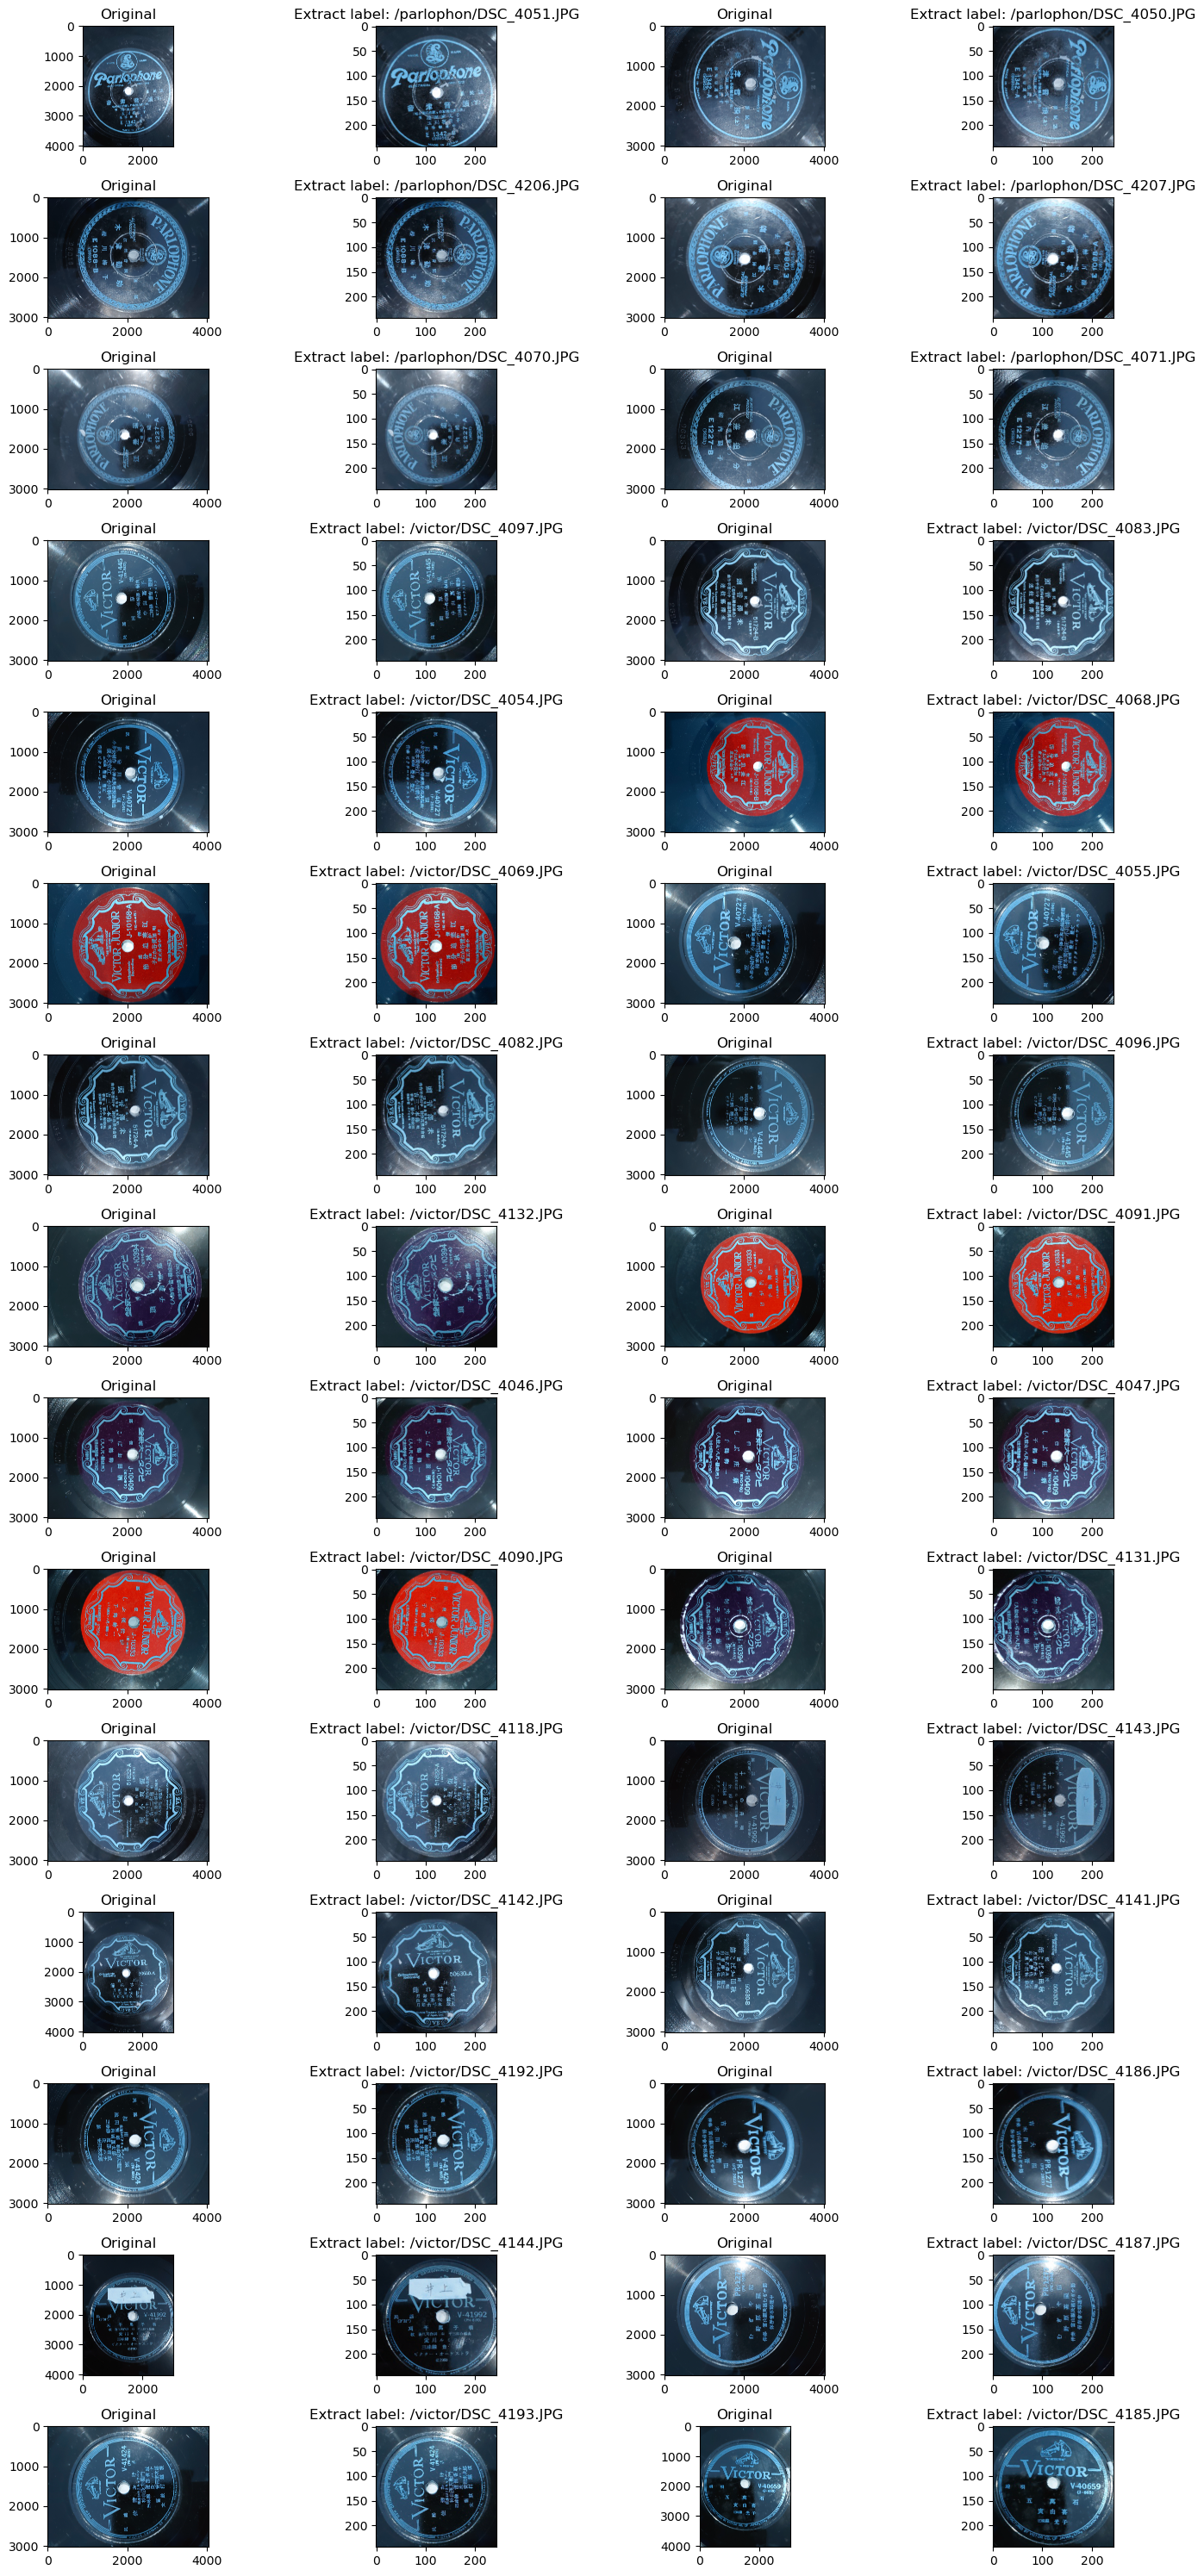

In [7]:
need_remake = False

samples = imagefiles[:30]
N = len(samples)
C = 2
R = ((N+1)//C)

_, ax = plt.subplots(ncols=2*C, nrows=R, figsize=(15,2*R))
ax = ax.flatten()

for j, imgfile in enumerate(samples):
    if j%20==0:
        print(j, '%sを処理中です...'%imgfile)
    k = 2*j
    img = cv2.imread(imgfile)
    outputfile = imgfile.replace('orig', 'extract_label')
    if need_remake:
        extract_img = extract_label(img)
        resize_img = cv2.resize(extract_img, (244,244))
        cv2.imwrite(outputfile, resize_img)
    else:
        resize_img = cv2.imread(outputfile)
    ax[k].imshow(img) 
    ax[k].set_title('Original')
    ax[k+1].imshow(resize_img)
    ax[k+1].set_title('Extract label: %s'%(imgfile.replace('images/orig','')))
plt.tight_layout()
plt.show()

奇数列がオリジナル画像、偶数列がラベル周辺を抽出した画像。
ほぼ上手く抽出できたようだ。

以下、明日以降の作業とする。